In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('Titanictrain.csv')
holdout = pd.read_csv('Titanictest.csv')
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Preprocessing the Dataset.

In [3]:
train[['SibSp','Parch','Fare','Cabin','Embarked']].describe(include="all",percentiles=[])

,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,204,889
unique,NaN,NaN,NaN,147,3
top,NaN,NaN,NaN,G6,S
freq,NaN,NaN,NaN,4,644
mean,0.523008,0.381594,32.204208,NaN,NaN
std,1.102743,0.806057,49.693429,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,NaN
50%,0.000000,0.000000,14.454200,NaN,NaN
max,8.000000,6.000000,512.329200,NaN,NaN


In [4]:
train[["Fare",'Cabin','Embarked']].value_counts()

Fare      Cabin        Embarked
263.0000  C23 C25 C27  S           4
120.0000  B96 B98      S           4
26.0000   F2           S           3
151.5500  C22 C26      S           3
89.1042   C92          C           2
                                  ..
32.3208   D50          S           1
33.5000   B19          S           1
34.0208   D46          S           1
34.6542   A5           C           1
512.3292  B51 B53 B55  C           1
Length: 156, dtype: int64

In [5]:
train.Cabin.str[0]

0      NaN
1        C
2      NaN
3        C
4      NaN
      ... 
886    NaN
887      B
888    NaN
889      C
890    NaN
Name: Cabin, Length: 891, dtype: object

In [6]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [7]:
def pre_process(df):
    
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_cabin(df)
    df = process_titles(df)
    
    
    for col in ["Age_categories","Fare_categories","Cabin_type","Title","Sex"]:
        df = create_dummies(df,col)
        
    return df

train = pre_process(train)
holdout = pre_process(holdout)


In [8]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Age_categories',
       'Fare_categories', 'Cabin_type', 'Title', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Sex_female',
       'Sex_male'],
      dtype='object')

### Exploring the Data

In [9]:
explore_cols = ["SibSp","Parch","Survived"]

explore = train[explore_cols].copy()

explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SibSp     891 non-null    int64
 1   Parch     891 non-null    int64
 2   Survived  891 non-null    int64
dtypes: int64(3)
memory usage: 21.0 KB


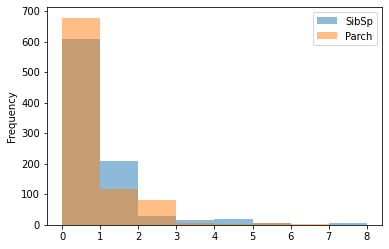

In [10]:
import matplotlib.pyplot as plt

explore.drop("Survived", axis=1).plot.hist(alpha=0.5, bins=8)
plt.show()

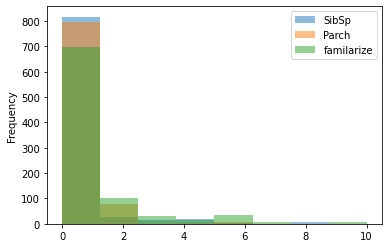

In [11]:
explore['familarize'] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop('Survived', axis=1).plot.hist(alpha=0.5, bins=8)
plt.show()

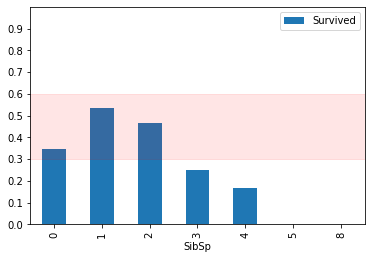

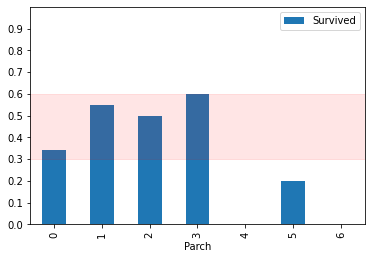

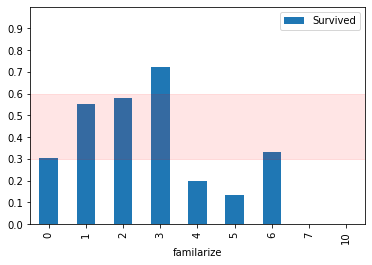

In [12]:
for col in explore.drop('Survived', axis=1).columns:
    pivot = explore.pivot_table(index=col, values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,0.1))
    plt.axhspan(0.3,0.6,alpha=0.1,color='red')
    plt.show()



The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

You can sum these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.


## Engineering New Features

In [13]:
def process_isalone(df):
    
    """ Adds a new column, isalone that has the value 0 if the passenger has one or more family members onboard, 
    and 1 if the passenger has zero family members onboard."""
    
    df['familarize'] = df[["SibSp","Parch"]].sum(axis=1)
    df['isalone'] = 0
    df.loc[(df['familarize']==0),'isalone']=1
    df.drop('familarize', axis=1)
    
    return df
    
train = process_isalone(train)
holdout = process_isalone(holdout)    

In [14]:
holdout

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Sex_female,Sex_male,familarize,isalone
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,...,0,0,1,0,0,0,0,1,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,...,0,0,0,1,0,0,1,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,...,0,0,1,0,0,0,0,1,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,...,0,0,1,0,0,0,0,1,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,...,0,0,0,1,0,0,1,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,-0.5,0,0,A.5. 3236,8.0500,S,...,0,0,1,0,0,0,0,1,0,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,...,0,0,0,0,0,1,1,0,0,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,...,0,0,1,0,0,0,0,1,0,1
416,1308,3,"Ware, Mr. Frederick",male,-0.5,0,0,359309,8.0500,S,...,0,0,1,0,0,0,0,1,0,1


## Selecting the Best-Performing Features

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   PassengerId                 891 non-null    int64   
 1   Survived                    891 non-null    int64   
 2   Pclass                      891 non-null    int64   
 3   Name                        891 non-null    object  
 4   Sex                         891 non-null    object  
 5   Age                         891 non-null    float64 
 6   SibSp                       891 non-null    int64   
 7   Parch                       891 non-null    int64   
 8   Ticket                      891 non-null    object  
 9   Fare                        891 non-null    float64 
 10  Embarked                    891 non-null    object  
 11  Age_categories              891 non-null    category
 12  Fare_categories             891 non-null    category
 13  Cabin_type          

In [16]:
cc = train.select_dtypes(np.number).isnull().sum()
cc

PassengerId                   0
Survived                      0
Pclass                        0
Age                           0
SibSp                         0
Parch                         0
Fare                          0
Age_categories_Missing        0
Age_categories_Infant         0
Age_categories_Child          0
Age_categories_Teenager       0
Age_categories_Young Adult    0
Age_categories_Adult          0
Age_categories_Senior         0
Fare_categories_0-12          0
Fare_categories_12-50         0
Fare_categories_50-100        0
Fare_categories_100+          0
Cabin_type_A                  0
Cabin_type_B                  0
Cabin_type_C                  0
Cabin_type_D                  0
Cabin_type_E                  0
Cabin_type_F                  0
Cabin_type_G                  0
Cabin_type_T                  0
Cabin_type_Unknown            0
Title_Master                  0
Title_Miss                    0
Title_Mr                      0
Title_Mrs                     0
Title_Of

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    """ Select only numeric columns with no missing value"""
    
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)


Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_G', 'Cabin_type_Unknown', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Sex_female', 'Sex_male', 'familarize', 'isalone']



##  Selecting and Tuning Different Algorithms

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]
    
    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    
    models = [ {"name": "LogisticRegression",
             "estimator": LogisticRegression(),
             "hyperparameters": 
             {'solver': ["newton-cg", "lbfgs", "liblinear"]}
             },
             
             {"name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
            {"name": "RandomForestClassifier",
          "estimator": RandomForestClassifier(random_state=1),
          "hyperparameters":
           {"n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]}
            }]
        
    for model in models:
        print(model['name'])
        print("_"* len(model['name']))
            
        grid = GridSearchCV(model['estimator'], param_grid = model["hyperparameters"],cv=10)
            
        grid.fit(all_X,all_y)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_model'] = grid.best_estimator_
            
        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

            
    return models
        

In [19]:
result = select_model(train,cols)

LogisticRegression
__________________


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Best Score: 0.8204619225967541
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
____________________
Best Score: 0.7800249687890137
Best Parameters: {'algorithm': 'kd_tree', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
______________________
Best Score: 0.8373158551810237
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 9}



In [20]:
# The is obvious that randomforest is the best classifier
result[2]['best_model']

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=5,
                       n_estimators=9, random_state=1)

## Making a Submission to Kaggle

In [21]:
def save_submission_file(model,cols,filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

best_rf_model = result[2]['best_model']
save_submission_file(best_rf_model,cols)